<span style='font-size:2.4em'>Procesamiento masivo de datos con SparkR</span>

<span style='font-size:1.5em'>VIII Jornadas de usuarios de R. Albacete, Castilla-La Mancha, 17 y 18 de noviembre de 2016</span>

Taller impartido por: <span style='font-size:1.2em'>Manuel Jesús Parra Royón</span>


![Alt](https://sites.google.com/site/manuparra/home/logoparty.png)

<HR>

# Aplicando técnicas de Machine Learning en SparkR

![Spark+R](https://sites.google.com/site/manuparra/home/SparkRlogo.png)

Como siempre para todos nuestros scripts con SparkR, cargamos la biblioteca, y creamos una nueva sesión de SparkR.

In [3]:
.libPaths(c(file.path(Sys.getenv("SPARK_HOME"),"R/lib/"),.libPaths()))
library(SparkR)
sparkR.session(appName="EntornoInicio", master = "local[*]", sparkConfig = list(spark.driver.memory = "1g"))


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union

Spark package found in SPARK_HOME: /usr/local/spark/


Launching java with spark-submit command /usr/local/spark//bin/spark-submit   --driver-memory "1g" sparkr-shell /tmp/Rtmp0Q9Wlx/backend_portc566aae3a9e 


Java ref type org.apache.spark.sql.SparkSession id 1 

<HR>
La biblioteca de ``SparkR`` actualmente soporta los siguientes algoritmos de aprendizaje automático : 

- modelo lineal generalizado, 
- modelo de regresión de supervivencia con tiempo de fallo acelerado (AFT), 
- modelo Bayes Naive y 
- modelo KMeans. 

SparkR utiliza MLlib para entrenar el modelo. Por tanto se puede analizar el resumen del modelo ajustado, predecir y   hacer predicciones sobre nuevos datos y escribir/leer el modelo para guardar / cargar los modelos ajustados. 

Además de ello, al igual que ocurre cuando usamos cualquier funcion en R, SparkR soporta el uso de fómulas, lo cual mejora bastante la adopción de SparkR para análisis de datos másivos.  SparkR soporta un subconjunto de los operadores de fórmula R disponibles para el ajuste del modelo, incluyendo '~', '.', ':', '+' y '-'.

####  Funciones enmascaradas

Dado que parte de SparkR está modelado en el paquete dplyr, ciertas funciones de SparkR comparten los mismos nombres con los de dplyr. Dependiendo del orden de carga de los dos paquetes, algunas funciones del paquete cargado primero son enmascaradas por las del paquete cargado después. 

``cov in package:stats``

``filter in package:stats``

``sample in package:base``


Por tanto hay siempre que usar el paquete que queramos usar al final de la importación de las bibliotecas para que se haga efectiva la función que queremos para SparkR.


## Algoritmos

El paquete SparkR soporta las siguientes funcionalidades de Machine Learning y Data mining

### Generalized Linear Model

Usamos la función de R

In [1]:

gaussianDF <- iris
gaussianTestDF <- iris
gaussianGLM <- glm(data = gaussianDF, Sepal.Length ~ Sepal.Width + Species, family = "gaussian")

summary(gaussianGLM)



Call:
glm(formula = Sepal.Length ~ Sepal.Width + Species, family = "gaussian", 
    data = gaussianDF)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.30711  -0.25713  -0.05325   0.19542   1.41253  

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.2514     0.3698   6.089 9.57e-09 ***
Sepal.Width         0.8036     0.1063   7.557 4.19e-12 ***
Speciesversicolor   1.4587     0.1121  13.012  < 2e-16 ***
Speciesvirginica    1.9468     0.1000  19.465  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.1918059)

    Null deviance: 102.168  on 149  degrees of freedom
Residual deviance:  28.004  on 146  degrees of freedom
AIC: 183.94

Number of Fisher Scoring iterations: 2


Usamos la función para glm de SparkR

In [4]:

irisDF <- suppressWarnings(createDataFrame(iris))
# Fit a generalized linear model of family "gaussian" with spark.glm
gaussianDF <- irisDF
gaussianTestDF <- irisDF
gaussianGLM <- spark.glm(gaussianDF, Sepal_Length ~ Sepal_Width + Species, family = "gaussian")

# Model summary
summary(gaussianGLM)



Deviance Residuals: 
(Note: These are approximate quantiles with relative error <= 0.01)
     Min        1Q    Median        3Q       Max  
-1.30711  -0.26011  -0.06189   0.19111   1.41253  

Coefficients:
                    Estimate  Std. Error  t value  Pr(>|t|)  
(Intercept)         2.2514    0.36975     6.0889   9.5681e-09
Sepal_Width         0.80356   0.10634     7.5566   4.1873e-12
Species_versicolor  1.4587    0.11211     13.012   0         
Species_virginica   1.9468    0.10001     19.465   0         

(Dispersion parameter for gaussian family taken to be 0.1918059)

    Null deviance: 102.168  on 149  degrees of freedom
Residual deviance:  28.004  on 146  degrees of freedom
AIC: 183.9

Number of Fisher Scoring iterations: 1


**¿Qué diferencias hay entre las dos?**

Calculamos el modelo

In [5]:
# Calculamos la predicción
gaussianPredictions <- predict(gaussianGLM, gaussianTestDF)
# Mostramos las predicciones
showDF(gaussianPredictions)

# Usamos la función de R de glm con la familia gaussian
gaussianGLM2 <- glm(Sepal_Length ~ Sepal_Width + Species, gaussianDF, family = "gaussian")
summary(gaussianGLM2)

# Ahora usamos la función de glm de spark para la familia binomial.
binomialDF <- filter(irisDF, irisDF$Species != "setosa")
binomialTestDF <- binomialDF
binomialGLM <- spark.glm(binomialDF, Species ~ Sepal_Length + Sepal_Width, family = "binomial")

# Imprimimos el modelo
summary(binomialGLM)

# Obtenemos la predicción
binomialPredictions <- predict(binomialGLM, binomialTestDF)
showDF(binomialPredictions)

+------------+-----------+------------+-----------+-------+-----+------------------+
|Sepal_Length|Sepal_Width|Petal_Length|Petal_Width|Species|label|        prediction|
+------------+-----------+------------+-----------+-------+-----+------------------+
|         5.1|        3.5|         1.4|        0.2| setosa|  5.1| 5.063856384860281|
|         4.9|        3.0|         1.4|        0.2| setosa|  4.9| 4.662075934441678|
|         4.7|        3.2|         1.3|        0.2| setosa|  4.7|  4.82278811460912|
|         4.6|        3.1|         1.5|        0.2| setosa|  4.6|4.7424320245253995|
|         5.0|        3.6|         1.4|        0.2| setosa|  5.0| 5.144212474944002|
|         5.4|        3.9|         1.7|        0.4| setosa|  5.4| 5.385280745195163|
|         4.6|        3.4|         1.4|        0.3| setosa|  4.6|  4.98350029477656|
|         5.0|        3.4|         1.5|        0.2| setosa|  5.0|  4.98350029477656|
|         4.4|        2.9|         1.4|        0.2| setosa|  4.4|


Deviance Residuals: 
(Note: These are approximate quantiles with relative error <= 0.01)
     Min        1Q    Median        3Q       Max  
-1.30711  -0.26011  -0.06189   0.19111   1.41253  

Coefficients:
                    Estimate  Std. Error  t value  Pr(>|t|)  
(Intercept)         2.2514    0.36975     6.0889   9.5681e-09
Sepal_Width         0.80356   0.10634     7.5566   4.1873e-12
Species_versicolor  1.4587    0.11211     13.012   0         
Species_virginica   1.9468    0.10001     19.465   0         

(Dispersion parameter for gaussian family taken to be 0.1918059)

    Null deviance: 102.168  on 149  degrees of freedom
Residual deviance:  28.004  on 146  degrees of freedom
AIC: 183.9

Number of Fisher Scoring iterations: 1



Deviance Residuals: 
(Note: These are approximate quantiles with relative error <= 0.01)
     Min        1Q    Median        3Q       Max  
-1.87365  -0.93236  -0.35150   0.96084   2.35669  

Coefficients:
              Estimate  Std. Error  t value  Pr(>|t|)  
(Intercept)   -13.046   3.0974      -4.2119  2.5319e-05
Sepal_Length  1.9024    0.51692     3.6802   0.00023303
Sepal_Width   0.40466   0.86283     0.46899  0.63908   

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 138.63  on 99  degrees of freedom
Residual deviance: 110.33  on 97  degrees of freedom
AIC: 116.3

Number of Fisher Scoring iterations: 5


+------------+-----------+------------+-----------+----------+-----+-------------------+
|Sepal_Length|Sepal_Width|Petal_Length|Petal_Width|   Species|label|         prediction|
+------------+-----------+------------+-----------+----------+-----+-------------------+
|         7.0|        3.2|         4.7|        1.4|versicolor|  0.0| 0.8271421517601683|
|         6.4|        3.2|         4.5|        1.5|versicolor|  0.0| 0.6044595910412891|
|         6.9|        3.1|         4.9|        1.5|versicolor|  0.0| 0.7916340858282183|
|         5.5|        2.3|         4.0|        1.3|versicolor|  0.0|0.16080518180591663|
|         6.5|        2.8|         4.6|        1.5|versicolor|  0.0| 0.6112229217050481|
|         5.7|        2.8|         4.5|        1.3|versicolor|  0.0|0.25550872955006354|
|         6.3|        3.3|         4.7|        1.6|versicolor|  0.0| 0.5681507664364411|
|         4.9|        2.4|         3.3|        1.0|versicolor|  0.0|0.05990570219970873|
|         6.6|       

### Accelerated Failure Time (AFT) Survival Regression Model

``spark.survreg()`` ajusta a un modelo de regresión AFT (accelerated failure time) sobre un SparkDataFrame. Para esta función no se permite el uso del operador . en la formula.

In [6]:
# Use the ovarian dataset available in R survival package
library(survival)

ovarianDF <- suppressWarnings(createDataFrame(ovarian))

head(ovarianDF)

aftDF <- ovarianDF
aftTestDF <- ovarianDF

#Aplicamos la función
aftModel <- spark.survreg(aftDF, Surv(futime, fustat) ~ ecog_ps + rx)

# Model summary
summary(aftModel)

# Prediction
aftPredictions <- predict(aftModel, aftTestDF)
showDF(aftPredictions)

futime,fustat,age,resid_ds,rx,ecog_ps
59,1,72.3315,2,1,1
115,1,74.4932,2,1,1
156,1,66.4658,2,1,2
421,0,53.3644,2,2,1
431,1,50.3397,2,1,1
448,0,56.4301,1,1,2


,Value
(Intercept),6.8966930
ecog_ps,-0.3850426
rx,0.5286457
Log(scale),-0.1234418


+------+------+-------+--------+---+-------+------+------------------+
|futime|fustat|    age|resid_ds| rx|ecog_ps| label|        prediction|
+------+------+-------+--------+---+-------+------+------------------+
|  59.0|   1.0|72.3315|     2.0|1.0|    1.0|  59.0| 1141.725636174727|
| 115.0|   1.0|74.4932|     2.0|1.0|    1.0| 115.0| 1141.725636174727|
| 156.0|   1.0|66.4658|     2.0|1.0|    2.0| 156.0|  776.854839028128|
| 421.0|   0.0|53.3644|     2.0|2.0|    1.0| 421.0|1937.0893352254895|
| 431.0|   1.0|50.3397|     2.0|1.0|    1.0| 431.0| 1141.725636174727|
| 448.0|   0.0|56.4301|     1.0|1.0|    2.0| 448.0|  776.854839028128|
| 464.0|   1.0| 56.937|     2.0|2.0|    2.0| 464.0|1318.0375179640846|
| 475.0|   1.0|59.8548|     2.0|2.0|    2.0| 475.0|1318.0375179640846|
| 477.0|   0.0|64.1753|     2.0|1.0|    1.0| 477.0| 1141.725636174727|
| 563.0|   1.0|55.1781|     1.0|2.0|    2.0| 563.0|1318.0375179640846|
| 638.0|   1.0|56.7562|     1.0|1.0|    2.0| 638.0|  776.854839028128|
| 744.

### K-Means

K-means clustering with 3 clusters of sizes 50, 52, 48

Cluster means:
  Petal.Length Petal.Width
1     1.462000    0.246000
2     4.269231    1.342308
3     5.595833    2.037500

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 3 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 2 3 3 3 3
[112] 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3
[149] 3 3

Within cluster sum of squares by cluster:
[1]  2.02200 13.05769 16.29167
 (between_SS / total_SS =  94.3 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

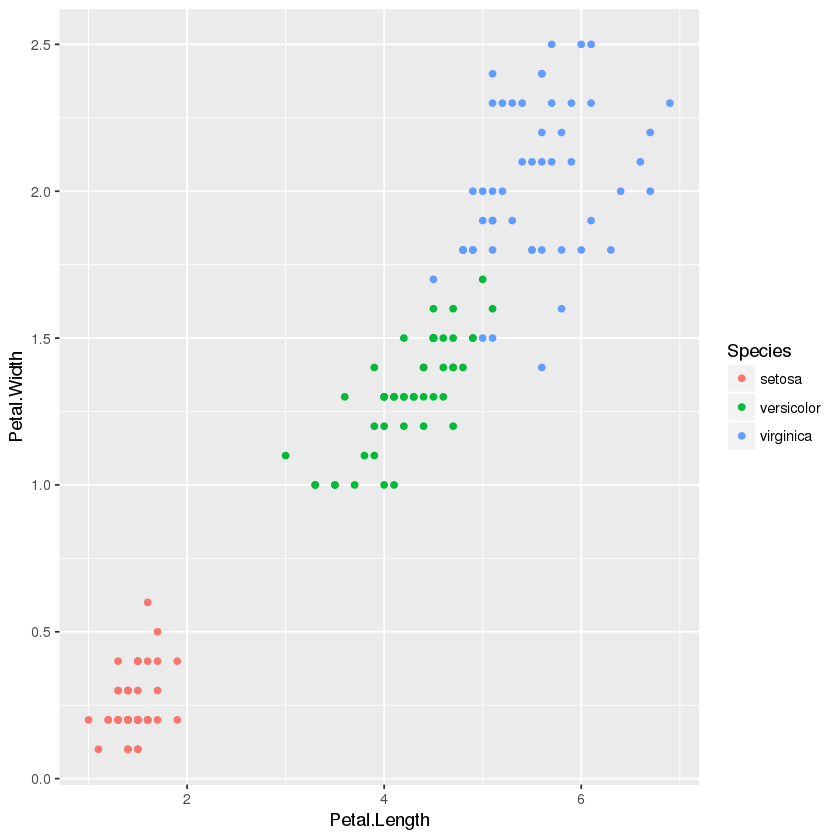

In [7]:

library(ggplot2)
ggplot(iris, aes(Petal.Length, Petal.Width, color = Species)) + geom_point()

set.seed(20)
irisCluster <- kmeans(iris[, 3:4], 3, nstart = 20)
irisCluster


In [ ]:
# Ajustamos un modelo k-medias. 

irisDF <- suppressWarnings(createDataFrame(iris))
kmeansDF <- irisDF
kmeansTestDF <- irisDF
kmeansModel <- spark.kmeans(kmeansDF, ~ Sepal_Length + Sepal_Width + Petal_Length + Petal_Width,
                            k = 3)

# Vemos el resumen
summary(kmeansModel)

# Vemos los resultados del ajuste
showDF(fitted(kmeansModel))

# y vemos la predicción
kmeansPredictions <- predict(kmeansModel, kmeansTestDF)
showDF(kmeansPredictions)

# Mostramos la información de los grupos.
table(kmeansModel$cluster, iris$Species)


### Naive Bayes


In [ ]:
### Aplicamos NAIVE.BAYES 

titanic <- as.data.frame(Titanic)
titanicDF <- createDataFrame(titanic[titanic$Freq > 0, -5])
nbDF <- titanicDF
nbTestDF <- titanicDF
nbModel <- spark.naiveBayes(nbDF, Survived ~ Class + Sex + Age)

# Resumen del modelo
summary(nbModel)

# Predicción
nbPredictions <- predict(nbModel, nbTestDF)
showDF(nbPredictions)


### Creación de Conjuntos de entrenamiento y prueba

Existen varias formas de hacer los conjuntos de prueba y test. Se pueden usar las funciones de muestreo (sample) que trabajan sobre los SparkDataFrames.

In [ ]:
train_df <- sample(df_training, withReplacement=FALSE, fraction=0.85, seed=42)
test_df <- except(df_training, train_df)

count(train_df)
count(test_df)

### Persistencia de los MODELOS de ML.

Si necesitamos almacenar el modelo que hemos ajustado podemo hacerlo mediante el uso de la funcion ``write.ml``. 
Al igual que luego podemos recuperarlo con ``read.ml``.

In [ ]:
modelPath <- tempfile(pattern = "ml", fileext = ".tmp")
write.ml(gaussianGLM, modelPath)
gaussianGLM2 <- read.ml(modelPath)

<HR>
# Zona de pruebas del NOTEBOOK en SparkR
![FooterSparkR](https://sites.google.com/site/manuparra/home/footer_SparkR_v2.png)
